# Fourier slice integration

In [1]:
import jax.numpy as jnp
from matplotlib import pyplot as plt

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities = read_atoms_from_pdb("./data/5w0s.pdb")
atom_potential = cxs.PengAtomicPotential(atom_positions, atom_identities)

# Multislice integrator

In [2]:
instrument_config = cxs.InstrumentConfig(
    shape=(150, 150),
    pixel_size=2.0,
    voltage_in_kilovolts=300.0,
)

In [3]:
voxel_potential = cxs.RealVoxelGridPotential.from_real_voxel_grid(
    atom_potential.as_real_voxel_grid((150, 150, 150), instrument_config.pixel_size),
    instrument_config.pixel_size,
)

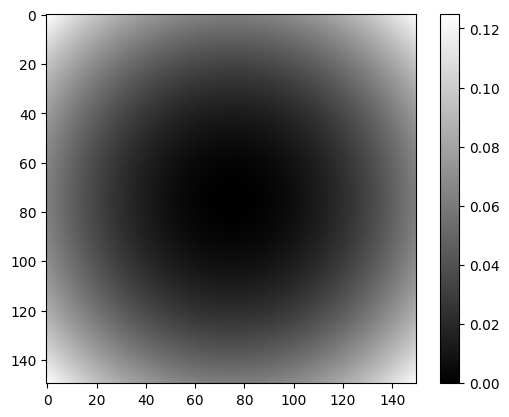

In [ ]:
kx, ky = instrument_config.padded_full_frequency_grid_in_angstroms.T
k2 = jnp.hypot(kx, ky) ** 2
plt.imshow(jnp.fft.fftshift(k2), cmap="gray")
plt.colorbar()

In [ ]:
from cryojax.experimental import FFTMultisliceIntegrator

In [ ]:
multislice_integrator = FFTMultisliceIntegrator(
    slice_thickness_in_voxels=3,
)

# exit_wave = multislice_integrator.compute_wavefunction_at_exit_plane(
#    atom_potential, instrument_config
# )
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# im0 = axes[0].imshow(exit_wave.real, cmap="gray")
# fig.colorbar(im0, ax=axes[0])
#
# im1 = axes[1].imshow(exit_wave.imag, cmap="gray")
# fig.colorbar(im1, ax=axes[1])

In [ ]:
import cryojax.experimental as cxe


pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=12.0,
    offset_y_in_angstroms=-14.0,
    view_theta=90.0,
    view_psi=20.0,
    view_phi=0.0,
)
structural_ensemble = cxs.SingleStructureEnsemble(voxel_potential, pose)
atom_structural_ensemble = cxs.SingleStructureEnsemble(atom_potential, pose)

wtf = cxe.WaveTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
ctf = cxs.ContrastTransferFunction(
    defocus_in_angstroms=wtf.defocus_in_angstroms,
    astigmatism_in_angstroms=wtf.astigmatism_in_angstroms,
    astigmatism_angle=wtf.astigmatism_angle,
    amplitude_contrast_ratio=wtf.amplitude_contrast_ratio,
)

In [ ]:
multislice_scattering_theory = cxe.MultisliceScatteringTheory(
    structural_ensemble, multislice_integrator, cxe.WaveTransferTheory(wtf)
)
high_energy_scattering_theory = cxe.HighEnergyScatteringTheory(
    structural_ensemble, cxs.NufftProjection(), cxe.WaveTransferTheory(wtf)
)
weak_phase_scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble, cxs.NufftProjection(), cxs.ContrastTransferTheory(ctf)
)

In [ ]:
multislice_imaging_pipeline = cxs.IntensityImagingPipeline(
    instrument_config, multislice_scattering_theory
)
high_energy_imaging_pipeline = cxs.IntensityImagingPipeline(
    instrument_config, high_energy_scattering_theory
)
weak_phase_imaging_pipeline = cxs.IntensityImagingPipeline(
    instrument_config, weak_phase_scattering_theory
)

im1, im2, im3 = (
    multislice_imaging_pipeline.render(),
    high_energy_imaging_pipeline.render(),
    weak_phase_imaging_pipeline.render(),
)

TypeError: cannot unpack non-iterable int object

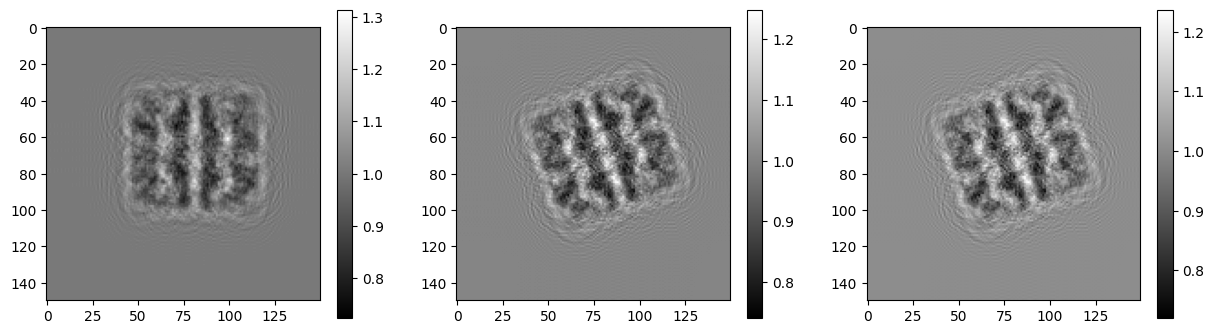

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
m1 = axes[0].imshow(im1, cmap="gray")
m2 = axes[1].imshow(im2, cmap="gray")
m3 = axes[2].imshow(im3, cmap="gray")
fig.colorbar(m1)
fig.colorbar(m2)
fig.colorbar(m3)